<a href="https://colab.research.google.com/github/eunhaday/AIFFEL_quest_cr/blob/master/Exploration/SQUest24/exp03_1128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py:   0%|          | 0.00/91.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/885M [00:00<?, ?B/s]

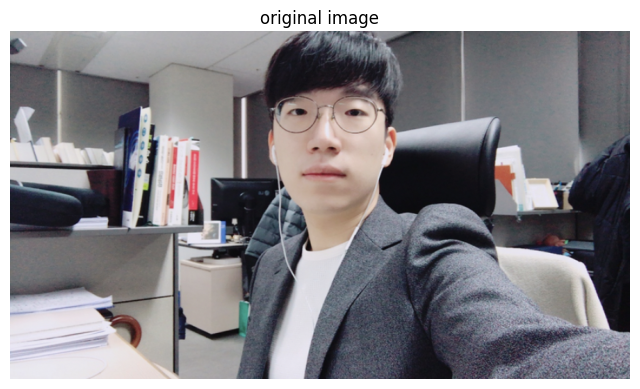

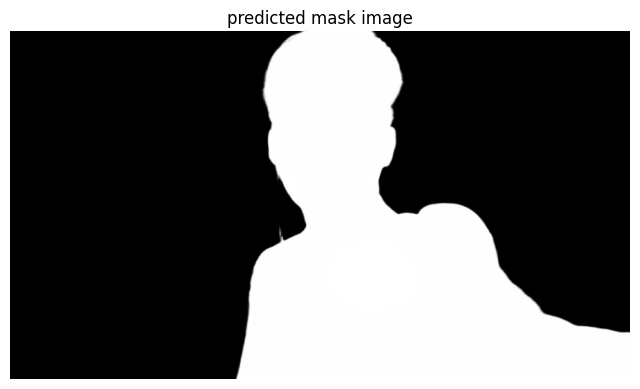

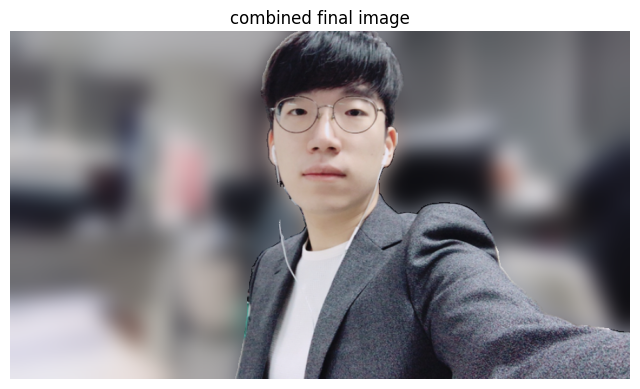

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install huggingface_hub
!pip install pillow
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install kornia


# Required Imports
from transformers import AutoImageProcessor, AutoModelForImageSegmentation
from PIL import Image
from torchvision import transforms
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = '/content/drive/MyDrive/my_image.png'


# 원본 이미지 로드 및 표시
original_image = Image.open(input_image_path).convert('RGB')
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('original image')
plt.axis('off')
plt.show()

# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)


# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BILINEAR)

# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image')
plt.axis('off')
plt.show()


# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.NEAREST)

# 마스크 이진화
mask_np = np.array(mask)
binary_mask = (mask_np > 0.5).astype(np.uint8) * 255
alpha_image = Image.fromarray(binary_mask, mode='L')

# 원본 이미지에 알파 채널 추가
image_rgba = image.convert('RGBA')
image_rgba.putalpha(alpha_image)

# 전경 이미지 추출
foreground_np = np.array(image_rgba)

# 배경 흐리게 처리
image_np = np.array(image.convert('RGB'))
blurred_background = cv2.GaussianBlur(image_np, (101, 101), 0)

# 알파 채널 추출
alpha_channel = binary_mask / 255.0
foreground_rgb = foreground_np[:, :, :3]

# 합성
combined = foreground_rgb * alpha_channel[:, :, np.newaxis] + blurred_background * (1 - alpha_channel[:, :, np.newaxis])
combined = combined.astype(np.uint8)

# 합성된 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(combined)
plt.title('combined final image')
plt.axis('off')
plt.show()